In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load and preprocess LFUD and Logic Datasets

In [ ]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'
path_to_csv = f'{data_root_path}/more_lfud_data.csv'

# LFUD data preprocessing
def load_lfud_data(path_to_csv = ''):
  '''Loads logical fallacy dataset (and optionally additional LFUD data if path_to_csv is provided).
      Arguments: path_to_csv (str): path to CSV file containing additional LFUD data.
      Returns: lfud_df (pd.DataFrame): DataFrame containing LFUD data.
  '''
  lfud_df = pd.read_csv('https://raw.githubusercontent.com/YandaGo/LFUD/main/LFUD.csv')[['proposition', 'sentence', 'fallacy_type', 'task2']]

  # Get only the first sentence of the question from task2 and set it as the context column
  # lfud_df["context"] = lfud_df["task2"].apply(lambda x: ast.literal_eval(x)["question"].split('\n')[0])

  # Drop task2 column and rename the columns
  lfud_df = lfud_df.drop(columns = ["task2"]).rename(columns = {
      "fallacy_type" : "output",
      "sentence": "input"
  })

  if path_to_csv:
    # Read in additional LFUD data CSV and combine with original lfud_df
    more_lfud_df = pd.read_csv(path_to_csv)[['proposition', 'input', 'output']]
    lfud_df = pd.concat([lfud_df, more_lfud_df], ignore_index = True).apply(lambda x: x.str.strip())
    lfud_df['input'] = lfud_df['input'].str.replace("’", "'")

  return lfud_df

# Logic Dataset preprocessing
def preprocess_logic_all():
    logic_all = (
        pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/edu_all.csv')
        .dropna(subset = ['source_article', 'updated_label'])
    )[lambda df: (df['updated_label'] != 'equivocation') & (df['updated_label'] != 'miscellaneous')]


    logic_all['updated_label'] = logic_all['updated_label'].replace('intentional', 'intentional fallacy')
    logic_all.loc[:, 'updated_label'] = logic_all['updated_label'].replace(
        {
            'fallacy of logic': 'deductive fallacy',
            'intentional': 'intentional fallacy'
        }
    )

    # Last 14 rows have old_label and source_article values in the wrong column. This code will shift the values in these columns one column to the right
    logic_all_to_preprocess = logic_all.tail(14).copy()
    logic_all_to_preprocess['source_article'] = logic_all_to_preprocess['old_label']

    logic_all = (pd.concat([logic_all.iloc[:-14], logic_all_to_preprocess], ignore_index = True)
                 .rename(columns = {'updated_label': 'output', 'source_article': 'input'})
                 .drop(columns = ['original_url', 'old_label', 'explanations', 'rationale'])
    )

    logic_all['input'] = logic_all['input'].str.replace('"', '')
    logic_all['input'] = logic_all['input'].str.replace('’', "'")
    logic_all = logic_all[['input', 'output']].apply(lambda x: x.str.strip())

    return logic_all


In [ ]:
# LFUD
lfud_df = load_lfud_data(path_to_csv = f'{data_root_path}/more_lfud_data.csv')
# full_context = ' \n'.join(lfud_df['context'].dropna().unique())
# lfud_df.drop(columns = 'context', inplace = True)

# Logic
logic_df = preprocess_logic_all()

# Map fallacy types to integers

In [ ]:
label_list = lfud_df['output'].unique().tolist()
label2id = {label: idx for idx, label in enumerate(label_list)}

lfud_df['label'] = lfud_df['output'].map(label2id)
logic_df['label'] = logic_df['output'].map(label2id)

# Drop output columns in LFUD and logic - string version of label no longer needed
lfud_df = lfud_df.drop(columns = ['output'])
logic_df = logic_df.drop(columns = ['output'])

label2id

{'faulty generalization': 0,
 'false causality': 1,
 'circular reasoning': 2,
 'ad populum': 3,
 'false dilemma': 4,
 'fallacy of relevance': 5,
 'ad hominem': 6,
 'appeal to emotion': 7,
 'fallacy of extension': 8,
 'fallacy of credibility': 9,
 'intentional fallacy': 10,
 'deductive fallacy': 11}

# Combine LFUD and Logic; Train-test split on LFUD propositions to avoid data leakage

In [ ]:
unique_props = lfud_df['proposition'].unique()

# Split LFUD propositions into train and test sets and do regular train-test split on Logic
lfud_train_props, lfud_val_props = train_test_split(unique_props, test_size=0.1, random_state=42)
logic_train_df, logic_val_df = train_test_split(logic_df, test_size=0.1, random_state=42)

# Filter LFUD dataset based on proposition membership
lfud_train_df = lfud_df[lfud_df['proposition'].isin(lfud_train_props)].reset_index(drop=True).drop(columns = ['proposition'])
lfud_val_df = lfud_df[lfud_df['proposition'].isin(lfud_val_props)].reset_index(drop=True).drop(columns = ['proposition'])

# Combine both LFUD and Logic
lfud_logic_train_df = pd.concat([lfud_train_df, logic_train_df], ignore_index = True)
lfud_logic_val_df = pd.concat([lfud_val_df, logic_val_df], ignore_index = True)

# Add output column temporarily for CSV purposes
lfud_logic_train_df['output'] = lfud_logic_train_df['label'].map({v:k for k, v in label2id.items()})
lfud_logic_val_df['output'] = lfud_logic_val_df['label'].map({v:k for k, v in label2id.items()})

lfud_logic_train_df.to_csv(f'{data_root_path}/lfud_logic_train.csv', index = False)
lfud_logic_val_df.to_csv(f'{data_root_path}/lfud_logic_val.csv', index = False)

# Load train and val splits of lfud_logic again

In [ ]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'

lfud_logic_train_df = pd.read_csv(f'{data_root_path}/lfud_logic_train.csv')
lfud_logic_val_df = pd.read_csv(f'{data_root_path}/lfud_logic_val.csv')

# Create Naive Bayes Classifier Baseline

In [ ]:
# Create pipeline: vectorizer + classifier
model = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", MultinomialNB())
])

# Train
model.fit(lfud_logic_train_df["input"], lfud_logic_train_df["label"])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

# Preprocess LogicClimate dataset for inference

In [ ]:
# 0. Load LogicClimate dataset for inference
logic_climate_all = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_all.csv').dropna(subset = ['source_article', 'logical_fallacies'])
logic_climate_all['logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('intentional', 'intentional fallacy')

# 1. Drop Equivocation
logic_climate_all = logic_climate_all[logic_climate_all['logical_fallacies'] != 'equivocation']

# 2. Map fallacy of logic label to deductive fallacy
logic_climate_all.loc[:, 'logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('fallacy of logic', 'deductive fallacy')

In [ ]:
# Predict using model
preds = model.predict(logic_climate_all["source_article"])

# Map integer predictions to string labels
id2label = {v: k for k, v in label2id.items()}
pred_labels = [id2label[pred] for pred in preds]

# Append predictions to the DataFrame
logic_climate_all["predicted_fallacy"] = pred_labels

Accuracy: 0.1276

Classification Report:
                        precision    recall  f1-score   support

            ad hominem       0.17      0.21      0.18        96
            ad populum       0.08      0.03      0.05        63
     appeal to emotion       0.31      0.08      0.12       141
    circular reasoning       0.00      0.00      0.00         7
     deductive fallacy       0.20      0.02      0.04        88
fallacy of credibility       0.32      0.08      0.12       131
  fallacy of extension       0.07      0.05      0.05        64
  fallacy of relevance       0.08      0.14      0.10       103
       false causality       0.10      0.34      0.16        73
         false dilemma       0.00      0.00      0.00        49
 faulty generalization       0.11      0.44      0.18       133
   intentional fallacy       0.33      0.05      0.09       337

              accuracy                           0.13      1285
             macro avg       0.15      0.12      0.09      12

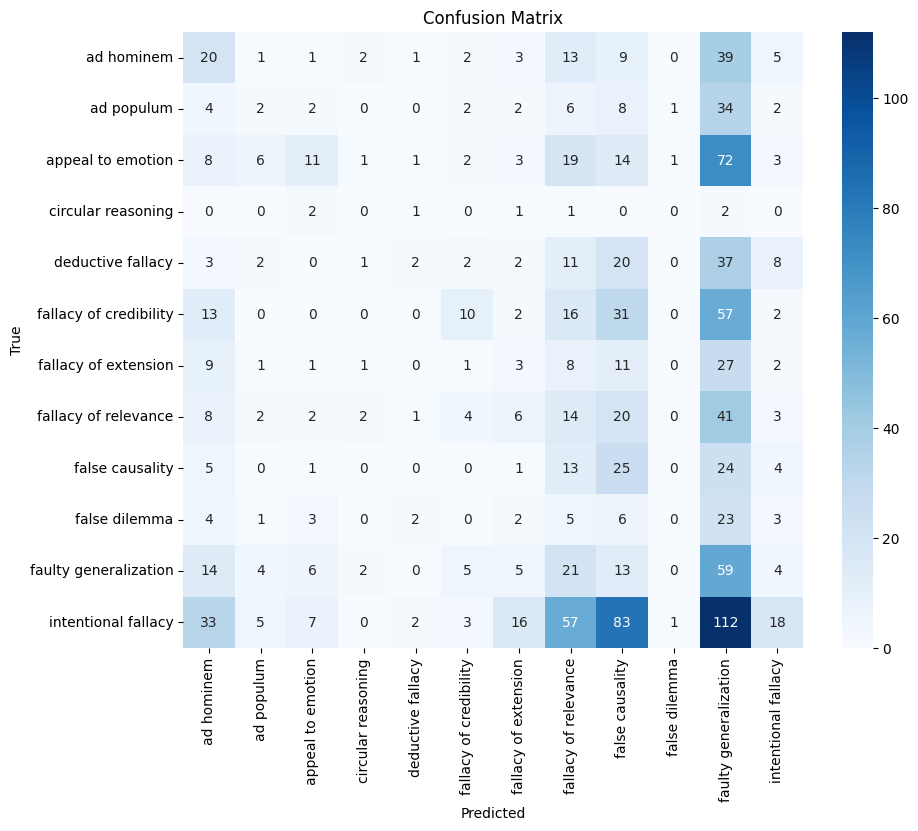

In [ ]:
# Make sure the labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['predicted_fallacy'].astype(str)

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(
    logic_climate_all["logical_fallacies"],
    logic_climate_all["predicted_fallacy"]
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()